In [ ]:
from sympy import symbols
import sympy
from sympy import *
from sympy import I
from sympy.physics.quantum import TensorProduct, Ket, Bra

aS, bS, cS, dS, xS, yS, zS, wS = symbols('a b c d x y z w')

state0 = Ket('0')
state1 = Ket('1')

print("For state to not be entangled, it must satisfy:")
display(Eq(Matrix([[aS*cS],[aS*dS],[bS*cS],[bS*dS]]),Matrix([[xS],[yS],[zS],[wS]])))
print("For this to have solution:")
display(Eq(aS*dS - bS*cS,0))

a = Rational(2,3)
b = Rational(1,3)
c = Rational(0)
d = Rational(-2,3)

print()
print("a)")
display(Eq(Add(Mul(a,d, evaluate=False), Mul(-1,Mul(b,c, evaluate=False), evaluate=False), evaluate=False), 0, evaluate=False))
display(Eq(a*d - b*c,0, evaluate=True))
print("Entangled state.");


print()
print("b)")
a = Rational(1,2)
b = -I/2
c = I/2
d = Rational(1,2)
display(Eq(Add(Mul(a,d, evaluate=False), Mul(-1,Mul(b,c, evaluate=False), evaluate=False), evaluate=False), 0, evaluate=False))
display(Eq(a*d - b*c,0, evaluate=True))
print("Possibly not entangled state, let's try to solve coefficients a, b,c and d:");

# Could not get Sympy solvers work with complex abs, so the last equation is just to force the normalization (calculated by hand)
solvedCoeffs = nonlinsolve([aS*cS-a, aS*dS-b, bS*cS-c, bS*dS-d, Abs(aS)**2+Abs(bS)**2-1, Abs(cS)**2+Abs(dS)**2-1, dS-1/sqrt(2)], [aS,bS,cS,dS])
display(solvedCoeffs)

print("equation could be solved. This gives us tensor product decomposition:")
display(Mul(Rational(1,2),TensorProduct(state1-I*state0,state1+I*state0)))


print()
print("c)")
a = Rational(1,2)
b = Rational(-1,2)
c = Rational(1,2)
d = Rational(1,2)
display(Eq(Add(Mul(a,d, evaluate=False), Mul(-1,Mul(b,c, evaluate=False), evaluate=False), evaluate=False), 0, evaluate=False))
display(Eq(a*d - b*c,0, evaluate=True))
print("Entangled state.");

In [5]:
# Problem 2 initializing algorithm. For now it is just the default qiskit initialize implementation.
import math
import numpy as np

from qiskit.exceptions import QiskitError
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import QuantumRegister
from qiskit.circuit import Instruction
from qiskit.circuit.exceptions import CircuitError
from qiskit.circuit.library.standard_gates.x import CXGate
from qiskit.circuit.library.standard_gates.ry import RYGate
from qiskit.circuit.library.standard_gates.u1 import U1Gate
from qiskit.circuit.reset import Reset

_EPS = 1e-10  # global variable used to chop very small numbers to zero


"""
Initialize qubit registers to desired arbitrary state.
"""

class InitializeOwn(Instruction):
    """Complex amplitude initialization.

    Class that implements the (complex amplitude) initialization of some
    flexible collection of qubit registers (assuming the qubits are in the
    zero state).
    Note that Initialize is an Instruction and not a Gate since it contains a reset instruction,
    which is not unitary.
    """

    def __init__(self, params):
        """Create new initialize composite.

        params (list): vector of complex amplitudes to initialize to
        """
        num_qubits = math.log2(len(params))

        # Check if param is a power of 2
        if num_qubits == 0 or not num_qubits.is_integer():
            raise QiskitError("Desired statevector length not a positive power of 2.")

        # Check if probabilities (amplitudes squared) sum to 1
        if not math.isclose(sum(np.absolute(params) ** 2), 1.0, abs_tol=_EPS):
            raise QiskitError("Sum of amplitudes-squared does not equal one.")

        num_qubits = int(num_qubits)

        super().__init__("initializeOwn", num_qubits, 0, params)


    def _define(self):
        """Calculate a subcircuit that implements this initialization

        Implements a recursive initialization algorithm, including optimizations,
        from "Synthesis of Quantum Logic Circuits" Shende, Bullock, Markov
        https://arxiv.org/abs/quant-ph/0406176v5

        Additionally implements some extra optimizations: remove zero rotations and
        double cnots.
        """
        # call to generate the circuit that takes the desired vector to zero
        disentangling_circuit = self.gates_to_uncompute()

        # invert the circuit to create the desired vector from zero (assuming
        # the qubits are in the zero state)
        initialize_instr = disentangling_circuit.to_instruction().inverse()

        q = QuantumRegister(self.num_qubits, 'q')
        initialize_circuit = QuantumCircuit(q, name='init_def')
        for qubit in q:
            initialize_circuit.append(Reset(), [qubit])
        initialize_circuit.append(initialize_instr, q[:])

        self.definition = initialize_circuit

    def gates_to_uncompute(self):
        """Call to create a circuit with gates that take the desired vector to zero.

        Returns:
            QuantumCircuit: circuit to take self.params vector to :math:`|{00\\ldots0}\\rangle`
        """
        q = QuantumRegister(self.num_qubits)
        circuit = QuantumCircuit(q, name='disentangler')

        # kick start the peeling loop, and disentangle one-by-one from LSB to MSB
        remaining_param = self.params

        for i in range(self.num_qubits):
            # work out which rotations must be done to disentangle the LSB
            # qubit (we peel away one qubit at a time)
            (remaining_param, thetas, phis) = InitializeOwn._rotations_to_disentangle(remaining_param)

            # perform the required rotations to decouple the LSB qubit (so that
            # it can be "factored" out, leaving a shorter amplitude vector to peel away)

            add_last_cnot = True
            if np.linalg.norm(phis) != 0 and np.linalg.norm(thetas) != 0:
                add_last_cnot = False

            if np.linalg.norm(phis) != 0:
                rz_mult = self._multiplex(U1Gate, phis, last_cnot=add_last_cnot)
                circuit.append(rz_mult.to_instruction(), q[i:self.num_qubits])

            if np.linalg.norm(thetas) != 0:
                ry_mult = self._multiplex(RYGate, thetas, last_cnot=add_last_cnot)
                circuit.append(ry_mult.to_instruction().reverse_ops(), q[i:self.num_qubits])

        return circuit


    @staticmethod
    def _rotations_to_disentangle(local_param):
        """
        Static internal method to work out Ry and Rz rotation angles used
        to disentangle the LSB qubit.
        These rotations make up the block diagonal matrix U (i.e. multiplexor)
        that disentangles the LSB.

        [[Ry(theta_1).Rz(phi_1)  0   .   .   0],
         [0         Ry(theta_2).Rz(phi_2) .  0],
                                    .
                                        .
          0         0           Ry(theta_2^n).Rz(phi_2^n)]]
        """
        remaining_vector = []
        thetas = []
        phis = []

        param_len = len(local_param)

        for i in range(param_len // 2):
            # Ry and Rz rotations to move bloch vector from 0 to "imaginary"
            # qubit
            # (imagine a qubit state signified by the amplitudes at index 2*i
            # and 2*(i+1), corresponding to the select qubits of the
            # multiplexor being in state |i>)
            (remains, add_theta, add_phi) = InitializeOwn._bloch_angles(local_param[2 * i: 2 * (i + 1)])

            remaining_vector.append(remains)

            # rotations for all imaginary qubits of the full vector
            # to move from where it is to zero, hence the negative sign
            thetas.append(-add_theta)
            phis.append(-add_phi)

        return remaining_vector, thetas, phis

    @staticmethod
    def _bloch_angles(pair_of_complex):
        """
        Static internal method to work out rotation to create the passed-in
        qubit from the zero vector.
        """
        [a_complex, b_complex] = pair_of_complex
        # Force a and b to be complex, as otherwise numpy.angle might fail.
        a_complex = complex(a_complex)
        b_complex = complex(b_complex)
        mag_a = np.absolute(a_complex)
        final_r = float(np.sqrt(mag_a ** 2 + np.absolute(b_complex) ** 2))
        if final_r < _EPS:
            theta = 0
            phi = 0
            final_r = 0
            final_t = 0
        else:
            theta = float(2 * np.arccos(mag_a / final_r))
            a_arg = np.angle(a_complex)
            b_arg = np.angle(b_complex)
            final_t = a_arg + b_arg
            phi = b_arg - a_arg

        return final_r * np.exp(1.J * final_t / 2), theta, phi

    def _multiplex(self, target_gate, list_of_angles, last_cnot=True):
        """
        Return a recursive implementation of a multiplexor circuit,
        where each instruction itself has a decomposition based on
        smaller multiplexors.

        The LSB is the multiplexor "data" and the other bits are multiplexor "select".

        Args:
            target_gate (Gate): Ry or Rz gate to apply to target qubit, multiplexed
                over all other "select" qubits
            list_of_angles (list[float]): list of rotation angles to apply Ry and Rz
            last_cnot (bool): add the last cnot if last_cnot = True

        Returns:
            DAGCircuit: the circuit implementing the multiplexor's action
        """
        list_len = len(list_of_angles)
        local_num_qubits = int(math.log2(list_len)) + 1

        q = QuantumRegister(local_num_qubits)
        circuit = QuantumCircuit(q, name="multiplex" + local_num_qubits.__str__())

        lsb = q[0]
        msb = q[local_num_qubits - 1]

        # case of no multiplexing: base case for recursion
        if local_num_qubits == 1:
            circuit.append(target_gate(list_of_angles[0]), [q[0]])
            return circuit

        # calc angle weights, assuming recursion (that is the lower-level
        # requested angles have been correctly implemented by recursion
        angle_weight = np.kron([[0.5, 0.5], [0.5, -0.5]], np.identity(2 ** (local_num_qubits - 2)))

        # calc the combo angles
        list_of_angles = angle_weight.dot(np.array(list_of_angles)).tolist()

        # recursive step on half the angles fulfilling the above assumption
        multiplex_1 = self._multiplex(target_gate, list_of_angles[0:(list_len // 2)], False)
        circuit.append(multiplex_1.to_instruction(), q[0:-1])

        # attach CNOT as follows, thereby flipping the LSB qubit
        circuit.append(CXGate(), [msb, lsb])

        # implement extra efficiency from the paper of cancelling adjacent
        # CNOTs (by leaving out last CNOT and reversing (NOT inverting) the
        # second lower-level multiplex)
        multiplex_2 = self._multiplex(target_gate, list_of_angles[(list_len // 2):], False)
        if list_len > 1:
            circuit.append(multiplex_2.to_instruction().reverse_ops(), q[0:-1])
        else:
            circuit.append(multiplex_2.to_instruction(), q[0:-1])

        # attach a final CNOT
        if last_cnot:
            circuit.append(CXGate(), [msb, lsb])

        return circuit


def initializeOwn(self, params, qubits):
    """Apply initialize to circuit."""
    if not isinstance(qubits, list):
        qubits = [qubits]
    return self.append(InitializeOwn(params), qubits)


QuantumCircuit.initializeOwn = initializeOwn

a1)


┌─────────────────────────────────────┐
q120_0: ┤0                                    ├
        │  INITIALIZEOWN(0.70711,0,0,0.70711) │
q120_1: ┤1                                    ├
        └─────────────────────────────────────┘

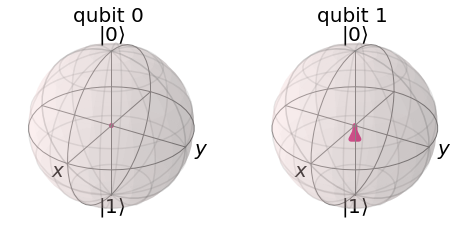

a2)


┌──────────────────────────────────────┐
q129_0: ┤0                                     ├
        │  INITIALIZEOWN(0.70711,0,0,-0.70711) │
q129_1: ┤1                                     ├
        └──────────────────────────────────────┘

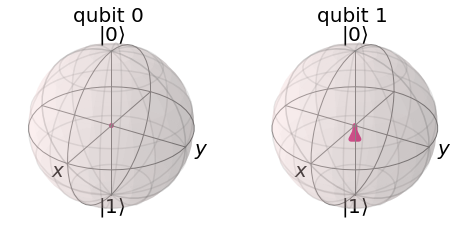

b1)


┌─────────────────────────────────────┐
q143_0: ┤0                                    ├
        │  INITIALIZEOWN(0,0.70711,0,0.70711) │
q143_1: ┤1                                    ├
        └─────────────────────────────────────┘

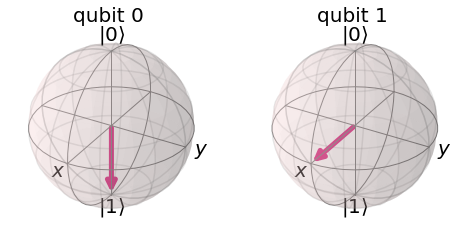

b2)


┌──────────────────────────────────────┐
q152_0: ┤0                                     ├
        │  INITIALIZEOWN(0,0.70711,0,-0.70711) │
q152_1: ┤1                                     ├
        └──────────────────────────────────────┘

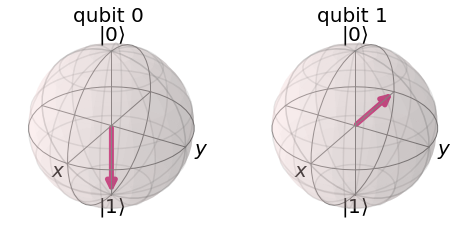

c)


┌──────────────────────────────────────────────────┐
q166_0: ┤0                                                 ├
        │  INITIALIZEOWN(0.86603,0.28868,0.28868,-0.28868) │
q166_1: ┤1                                                 ├
        └──────────────────────────────────────────────────┘

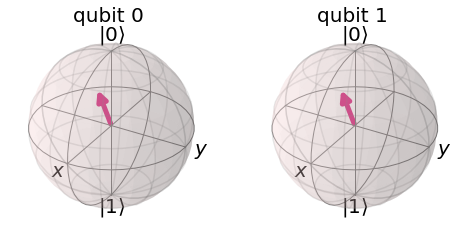

In [6]:
# Exercise 2, problem 2 implement own initialize algorithm
import math
from qiskit import QuantumCircuit, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_bloch_multivector
from qiskit import BasicAer
backend = BasicAer.get_backend('statevector_simulator')

print("a1)")
a1_coeffs = [1/math.sqrt(2), 0, 0, 1/math.sqrt(2)]
q = QuantumRegister(2)
qc = QuantumCircuit(q)
# This is just copy/pasted qiskit initialize. Could not think anything else after seeing how it was implemented.
qc.initializeOwn(a1_coeffs, [q[0],q[1]])
display(qc.draw())
job = execute(qc, backend)
qc_state = job.result().get_statevector(qc)
display(plot_bloch_multivector(qc_state))

print("a2)")
a2_coeffs = [1/math.sqrt(2), 0, 0, -1/math.sqrt(2)]
q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.initializeOwn(a2_coeffs, [q[0],q[1]])
display(qc.draw())
job = execute(qc, backend)
qc_state = job.result().get_statevector(qc)
display(plot_bloch_multivector(qc_state))

print("b1)")
b1_coeffs = [0, 1/math.sqrt(2), 0, 1/math.sqrt(2)]
q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.initializeOwn(b1_coeffs, [q[0],q[1]])
display(qc.draw())
job = execute(qc, backend)
qc_state = job.result().get_statevector(qc)
display(plot_bloch_multivector(qc_state))

print("b2)")
b2_coeffs = [0, 1/math.sqrt(2), 0, -1/math.sqrt(2)]
q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.initializeOwn(b2_coeffs, [q[0],q[1]])
display(qc.draw())
job = execute(qc, backend)
qc_state = job.result().get_statevector(qc)
display(plot_bloch_multivector(qc_state))

print("c)")
c_coeffs = [3/math.sqrt(12), 1/math.sqrt(12), 1/math.sqrt(12) , -1/math.sqrt(12)]
q = QuantumRegister(2)
qc = QuantumCircuit(q)
qc.initializeOwn(c_coeffs, [q[0],q[1]])
display(qc.draw())
job = execute(qc, backend)
qc_state = job.result().get_statevector(qc)
display(plot_bloch_multivector(qc_state))

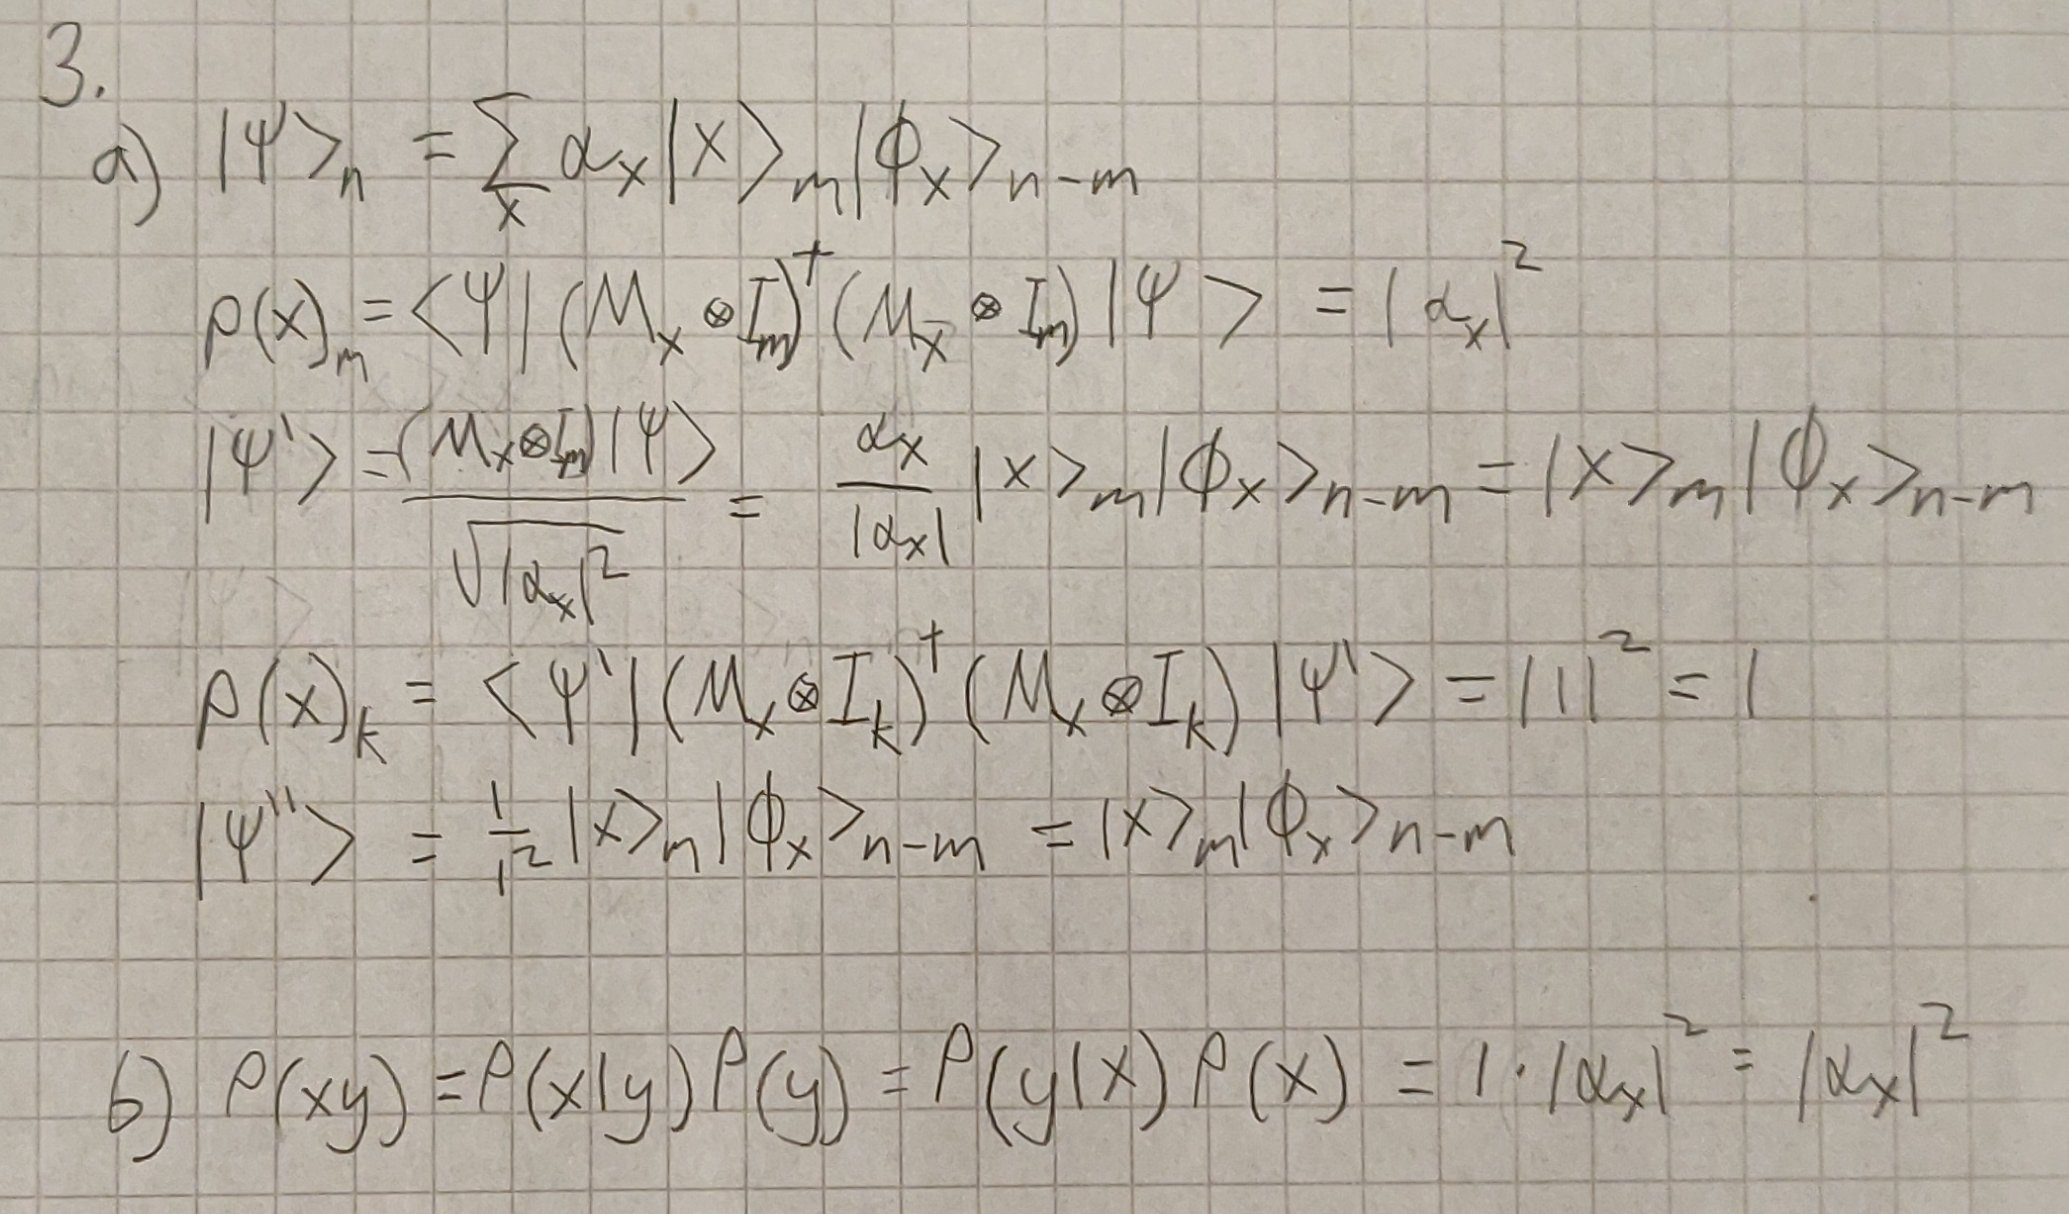

In [9]:
# Problem 3, I dont know how to do this, but i quess the point is 
# that after the quantum measurement the subsequent measurements do
# not give any additional information and thus it does not matter how
# many qubits one measures, just one is enough.
from IPython.display import Image
Image("demo2problem3Louko.jpg")